In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize = (9,3)
else:
    figsize = (13,4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wlen = 48
wdata = nab.sliding_window_1D(data, wlen=wlen)


# ------------------------------------------------------------------
# For a later comparison: train a KDE model
# ------------------------------------------------------------------

# Compute the bandhwidth
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1) / 1.34) * m**(-0.2)
print(f'KDE bandwidth: {h:.3f}')

# Build and fit a density estimator
print('Fitting a KDE estimator')
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
KDE bandwidth: 0.035
Fitting a KDE estimator


# Handling Seasonality

## About Our Autoregression Attempt

**About our autoregression attempt:**

* It worked reasonably well
* ...But the error signal was very noisy
* And some anomalies went completely undetected

**I bet you know a possible cause**

...And _some_ problems are in fact caused by the presence of a _period_

* Periodic-like behavior in time series is referred to as _seasonality_
* In principle, linear regression can deal with periodic data
* ...As long as the period is _shorter_ than the observed window
* However, other periods are still a problem

**We will now explore the idea of _getting rid of_ the periodicity**

## Identification of the Seasonality

**The first step to removing seasonality is its identification**

* One way to do it is using an autocorrelation plot (for the training data)

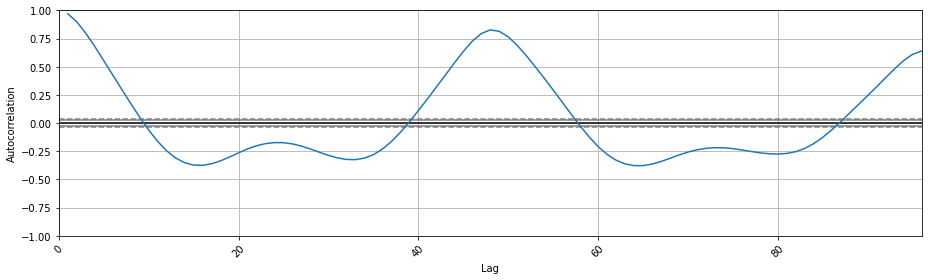

In [4]:
nab.plot_autocorrelation(data_tr, max_lag=96, figsize=figsize)

By looking up to > 48 lags, the daily period is evident

## Identification of the Seasonality

**However, using an autocorrelation plot has its _problems_:**

Peaks repeat:

* The peak at 48 unit lag will repeat at 96 and so on
* How can we say  whether it's a single period or multiple periods?

Multiple periods may disturb each other:

* A shorter period may make a longer one less evident
* Non co-prime periods hide each other

Trends cause even more noise:

* If the data has a trend (e.g. generally increasing or decreasing)...
* ...All correlations due to seasonal behavior will be weaker

## Identification of the Seasonality

**A better method consist in using frequence analysis**

In particular, we can compute the _Fast Fourier Transform_ of our signal

* Without going too deep, a FFT is decomposition of a _discrete_ signal...
* ...Into a _discrete_ set of sine/cosine components

**Given a signal $x$ with $N$ samples, its FFT has also $N$ components**

The _amplitudes $y$_ of the components are defined so that:

$$
x_n = \frac{1}{N} \sum_{k=0}^{N-1} y_k e^{2\pi i \frac{kn}{N}}
$$

I.e. the whole signal can be reconstructed from its decomposition

* $x_n$ is the $n$-th element in the discrete signal
* Each amplitude $y_k$ is assigned to a _frequency_

## FFT in numpy

**In numpy, we can compute an FFT via:**

In [5]:
from numpy.fft import fft
y = fft(data_tr['value'])

We can get the corresponding frequencies with:

In [6]:
from numpy.fft import fftfreq
f = fftfreq(len(data_tr))
print(f)

[ 0.          0.00018116  0.00036232 ... -0.00054348 -0.00036232
 -0.00018116]


* The frequencies are in cycles/time unit (30 minutes, in our case)
* A different sampling frequency may be specified, if you wish

## FFT in numpy

**For a _real-valued_ signal, the FFT is always _symmetric_**

* So, we care only about the positive frequencies (by convention, _the first half_)
* The 0 frequency (constant component) is also not relevant for us

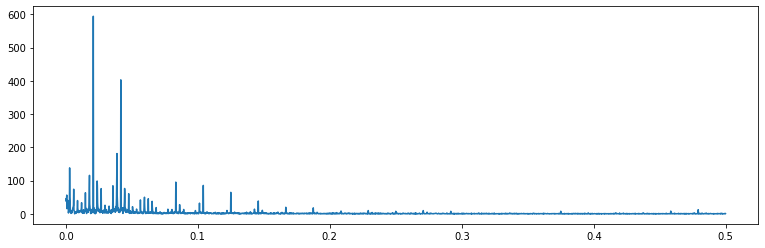

In [8]:
n = len(data_tr)
plt.figure(figsize=figsize)
plt.plot(f[1:n//2], np.abs(y[1:n//2]))
plt.xticks()
plt.show()

## Getting the Peak Frequencies

**Let us select all frequecies with amplitude greater than 100**

First, we focus on the positive frequencies

In [9]:
yp = y[1:n//2]
fp = f[1:n//2]

Then, we select the frequencies with (absolute) amplitude above 100:

In [10]:
fp_peak = fp[np.abs(yp) >= 100]

...And we invert them to obtain the periods (in time steps):

In [11]:
1/fp_peak

array([345.        ,  55.75757576,  48.        ,  25.91549296,
        25.79439252,  24.        ])

## Getting the Peak Frequencies

**Let's discard the duplicates and consider them one by one**

In [12]:
np.unique(np.round(1/fp_peak))

array([ 24.,  26.,  48.,  56., 345.])

There are a few clusters:

* 345: this is a _weekly_ period (345 / 48 = 7.18). Rounded to 48*7 = 336
* 56, 48: this is the main, _daily_ period. Rounded to 48
* 24: this is a _half-day_ period. Rounded to 24

## Getting the Peak Frequencies

**The periods are not co-prime**

* ..I.e. they are _multiples_ one of each other
* In this situation, the _longest period_ tends to be the most important one

**In fact, the longest period _conveys information_ about its sub-multiples**

* Taxis requested at 7am last week...
* ...Are likely similar to those requested at 7am yesterday
* The same goes for all sub-multiples

**In our situation:**

* All periods are (roughly) submultiples of one week
* ...So we can _focus on the weekly period_

## Differencing

**A simple approach to handle seasonality consist in _differencing_**

Our predictor becomes the _sum of two predictors_ (i.e. a type of ensemble):

* The linear regression model, $f(x, \theta)$
* A predictor $g(x, d)$ that outputs the target exactly $d$ steps before:

$$
g(x_i, d) = \hat{y}_{i-d}
$$

Where:

* $x_i$ is the value of the series for the $i$-th time step
* $d$ is the period, $\hat{y}_{i-d}$ is the target value $d$ time steps earlier

**The idea is to _let the a dedicated predictor handle the period_**



## Differencing

**With the differencing approach we wish to have**

$$
g(x_i, d) + f(x_i, \theta) \simeq \hat{y}_i
$$

* Where $\hat{y}_i$ is the target for the $i$-th time step (e.g. the value of the next step)

**About learning the (ensemble) predictor:**

* Training $g(x, d)$ first requires to identify the period
* Once we know $d$, the we can rewrite the equation as:

$$
f(x_i, d) \simeq \hat{y}_i - g(x_i, d)
$$

* The target for the linear regressor is obtained by taking the original target
* ...And _subtracting the target $d$ step earlier_




## Differencing

**The use of a difference operator is the reason for the name "differencing"**

We obtain the linear regressor targets by subtraction:

In [13]:
periods = [1, 336]
deltas = []
data_d = data.copy()
for d in periods:
    delta = data_d.iloc[:-d]
    data_d = data_d.iloc[d:] - delta.values
    deltas.append(delta)

* The `values` field returns the data as a numpy array (_without an index_)
* We use it to keep the index of `data_d.iloc[d:]`
* We store all subtracted vectors so we can _reverse the transformation_
    * I.e. so that we can later compute the value of the $g(x, d)$ predictor

## Differencing

**The use of a difference operator is the reason for the name "differencing"**

We obtain the linear regressor targets by subtraction:

In [14]:
periods = [1, 336]
deltas = []
data_d = data.copy()
for d in periods:
    delta = data_d.iloc[:-d]
    data_d = data_d.iloc[d:] - delta.values
    deltas.append(delta)

**We have also added a "1" period**

* This is not captured by frequency analysis via FFT
* ...But most signals have some "inertia"
* ...Hence, just _repeating the last value_ has a strong predicting value

The act of just predicting the last value has even name: _persistence_ predictor

## Differencing

**We can wrap the algorithm in a function**

This is available in the `nab` module

```python
def apply_differencing(data, lags):
    deltas = {}
    data_d = data.copy()
    for d in lags:
        delta = data_d.iloc[:-d]
        data_d = data_d.iloc[d:] - delta.values
        deltas[d] = delta
    return data_d, deltas
```

In [15]:
data_d, deltas = nab.apply_differencing(data, periods)

## Differencing

**We can now plot the resulting series**

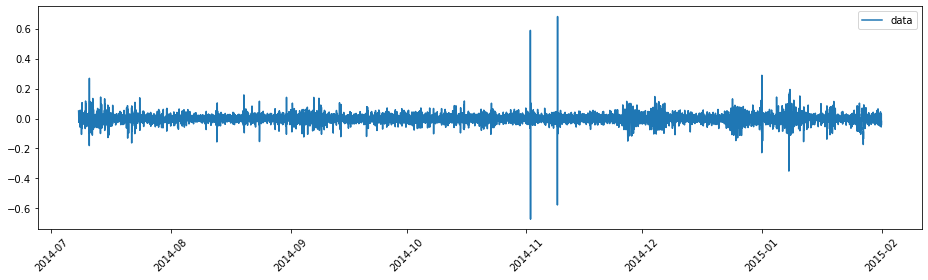

In [17]:
nab.plot_series(data_d, figsize=figsize)

* Periods are _no longer visible_!

## Preparing the Data

**Now we need to choose a sliding window length**

For this task, the best tool is still an autocorrelation plot

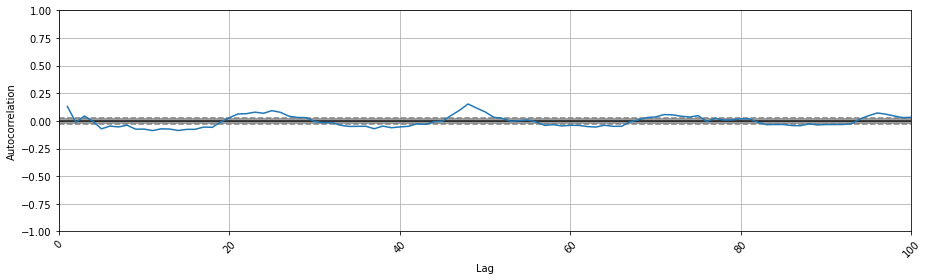

In [19]:
nab.plot_autocorrelation(data_d, figsize=figsize)

* Correlations are now very weak: we can use a small window

## Preparing the Data

**Then, we can actually apply the sliding window**

In [20]:
wlen_d = 3
wdata_d = nab.sliding_window_1D(data_d, wlen=wlen_d)
wdata_d.head()

,0,1,2
timestamp,,,
2014-07-08 01:30:00,0.050538,0.038159,-0.024660
2014-07-08 02:00:00,0.038159,-0.024660,-0.025088
2014-07-08 02:30:00,-0.024660,-0.025088,-0.001284
2014-07-08 03:00:00,-0.025088,-0.001284,0.005400
2014-07-08 03:30:00,-0.001284,0.005400,0.001877


...And then separate input and output

In [21]:
wdata_d_out = data_d.iloc[wlen_d:]['value']
wdata_d_in = wdata_d.iloc[:-1]

## Fitting the Autoregressor

**Now, we can train again our regressor**

In [22]:
wdata_d_in_tr = wdata_d_in[wdata_d_in.index < train_end]
wdata_d_out_tr = wdata_d_out[wdata_d_out.index <= train_end]

reg_d = LinearRegression()
reg_d.fit(wdata_d_in_tr, wdata_d_out_tr);

Then we obtain the predictions:

In [23]:
pred_d = reg_d.predict(wdata_d_in)
pred_d = pd.Series(index=wdata_d_out.index, data=pred_d)

* These are predictions for the signal _after differencing_
* They do not reflect the scale of the _original_ signal
* ...And therefore they are not yet enough

## Fitting the Autoregressor

**Differencing leads to a more complex predictor**

* We have the differencing operation + the Linear Regression model
* Once again, we have an _ensemble_

**Getting the actual predictions requires to _reverse_ the differencing operation**

In [24]:
dsum = 0
pred = pred_d.copy()
for i, d in reversed(list(enumerate(periods))):
    delta = deltas[i].values.reshape((-1,))
    pred = pred + delta[wlen_d+dsum:]
    dsum +=  d
targets = data.iloc[wlen_d+dsum:]['value']

* We do it by summing the _right-most part_ of the residual vectors we stored
  - For this we visit the periods in reverse order
  - ...And keep a sum (`dsum`) of the processed periods
* We also need to take into account the window for the Linear Regression model

## Fitting the Autoregressor

**We can wrap even this operation in a function**

This is available in the `nab` module

```python
def deapply_differencing(pred, deltas, lags, extra_wlen=0):
    dsum = 0
    pred_dd = pred.copy()
    for i, d in reversed(list(enumerate(lags))):
        delta = deltas[i].values.reshape((-1,))
        pred_dd = pred_dd + delta[extra_wlen+dsum:]
        dsum +=  d
    return pred_dd
```

In [25]:
pred = nab.deapply_differencing(pred_d, deltas, periods, wlen_d)

## Prediction Quality

**We can check the prediction quality via a scatter plot:**

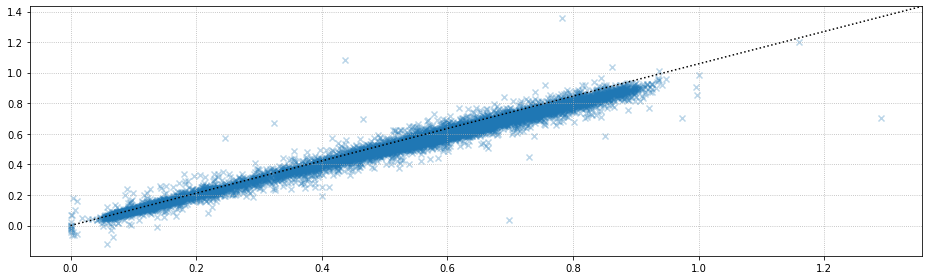

In [27]:
nab.plot_prediction_scatter(targets, pred, figsize=figsize)

...And via the R2 score:

In [28]:
r2_score(targets, pred)

0.9818505405355401

## Alarm Signal

**Now we compute the errors to obtain our signal**

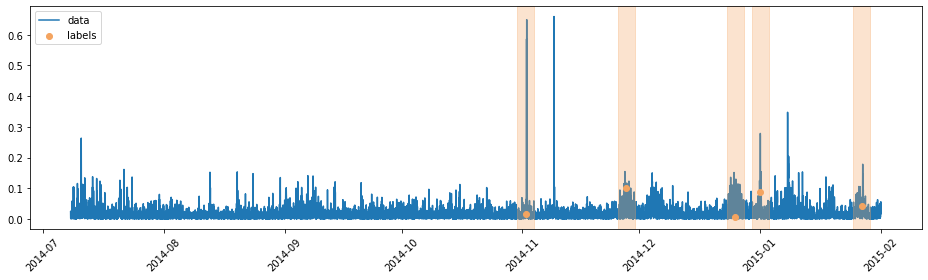

In [30]:
err_d = targets - pred
signal_d = np.abs(err_d)
nab.plot_series(signal_d, labels, windows, figsize=figsize)

## Effect of the Threshold

**Here's the cost surface w.r.t. the threshold**

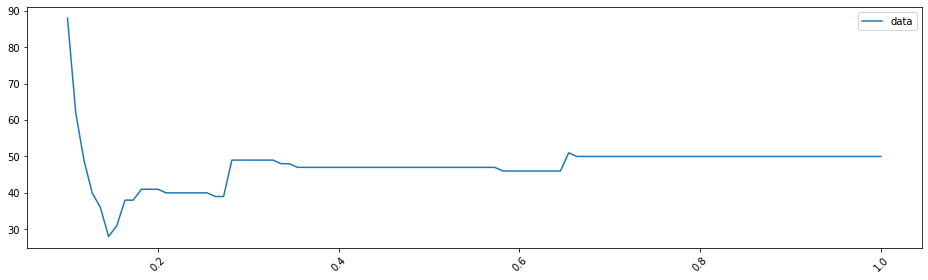

In [32]:
thr_range = np.linspace(0.1, 1, 100)
cost_range = [cmodel.cost(signal_d, labels, windows, thr)
              for thr in thr_range]
cost_range = pd.Series(index=thr_range, data=cost_range)
nab.plot_series(cost_range, figsize=figsize)

## Threshold Optimization

**We can choose the value of $\theta$ in the usual way**

In [33]:
signal_d_opt = signal_d[signal_d.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]

best_thr, best_cost = nab.opt_thr(signal_d_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost}')

Best threshold: 0.155, corresponding cost: 10


Over all the dataset

In [34]:
ctst = cmodel.cost(signal_d, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 31


## Considerations

**We have seen just _one way to handle seasonality_:**

* Another method consists in augmenting the input data...
* ...With a frequency component in the form $w_1 \cos \pi \omega t + w_2 \sin \pi \omega t$
  - $\omega$ corresponds to the frequency we want to capture
  - $w_1$ and $w_2$ are weights to be tuned by Linear Regression
* In practice, we add one column for $\cos \pi\omega t$ and one for $\sin \pi\omega t$

**Differencing is an idea with a _broader scope_:**

* It is at the heart of so-called "integrated" linear approaches for time series
* ...It's the "I" in ARIMA models
  - ...Which BTW stands for Auto Regressive Integrated Moving Average

## Considerations

**Seasonality and time-dependent models _rely on periods_**

* ...But they do _different things_!
* In one case we _model_ the period effect, and then we _remove_ it
  - E.g. differencing, using a frequency component
* In time-indexed models we _learn models that focus on specific times_
  - There is no explicit time model
  - ...Or, better, the time model is a lookup table with distinct predictors
* Hard to say a priori which approach can work best

Both approaches not tied to Linear Regression and KDE

**Removing seasonality is related to _gradient boosting_**

* I.e. to the idea of building an ensemble as a sequence of (summed) predictors
* ..Each one trying to correct the mistake of the sub-sequence that precedes it